In [1]:
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk

import pickle
import shutil
import os
import glob

from retry import retry

In [2]:
class RealTimeShelve:
    def __init__(self, savedir='./shelf/'):
        """
        ファイルを毎回外部に保存/外部から読み取ることで、
        subprocess等を使わずにプロセス間で値を共有する
        """
        self.savedir = savedir
        os.makedirs(self.savedir, exist_ok=True)
        
        # 前回取得したときの値　
        # ファイルの同時アクセスによりPermission Errorになった際に使う
        self.last_values = {} 
    
    def path(self, key):
        return f"{self.savedir}{key}.pkl"
    
    def path2key(self, path):
        return '.'.join(path.split('\\')[-1].split('.')[:-1])

    @retry(PermissionError, tries=10)
    def __setitem__(self, key, value):
        with open(self.path(key), 'wb') as f:
            pickle.dump(value, f)
        self.last_values[key] = value

    def __getitem__(self, key):
        if os.path.exists(self.path(key)):
            try:
                with open(self.path(key), 'rb') as f:
                    value = pickle.load(f)
                    self.last_values[key] = value
                    return value
            except PermissionError:
                # 書き換え中にアクセスしてしまったとき
                # 以前保管した値があったらそれを返す
                return self.last_values[key]
        else:
            raise KeyError(key)
    
    def _get_dict(self):
        d = {}
        for path in glob.glob(f"{self.savedir}*"):
            with open(path, 'rb') as f:
                d[self.path2key(path)] = pickle.load(f)
        return d
    
    def items(self):
        return self._get_dict().items()
    
    def keys(self):
        return self._get_dict().keys()
    
    def values(self):
        return self._get_dict().values()
    
    def __iter__(self):
        yield from self.keys()

In [3]:
class TkParams:
    def __init__(self, savedir='./tk_params/', reset=False):
        self.savedir = savedir
        if reset:
            shutil.rmtree(savedir)
            os.makedirs(savedir)
            os.makedirs(f"{savedir}widgets/")
        
        self.widgets = {
            "slider": RealTimeShelve(f"{savedir}widgets/slider/"),
            "toggle_button": RealTimeShelve(f"{savedir}widgets/toggle_button/"),
        }
        
        self.sliders = RealTimeShelve(f"{savedir}slider/")
        self.toggle_buttons = RealTimeShelve(f"{savedir}toggle_button/")
        
    def get_float(self, key, from_=0, to=1, resolution=None, default=None):
        if key in self.sliders:
            # GUIにすでにウィジェットがあったら
            return float(self.sliders[key])
        else:
            # GUIにまだウィジェットがなかったら
            # ウィジェットを追加するよう伝えつつ、今回はデフォルト値を返す
            self.widgets["slider"][key] = {
                'name': key,
                'from_': from_,
                'to': to,
                'resolution': resolution,
                'default': default,
            }
            return from_ if default is None else default
        
    def get_bool(self, key, default=None):
        if key in self.toggle_buttons:
            return bool(self.toggle_buttons[key])
        else:
            self.widgets["toggle_button"][key] = {
                'name': key,
            }
            return False if default is None else default

In [4]:
class Application(tk.Tk):
    def __init__(self, title='GUI App', dt=100):
        super().__init__()
        self.title(title)
        
        # 画面をグラフを配置する場所とボタン等を配置する場所に分ける
        self.canvas_frame = tk.Frame(self)
        self.canvas_frame.pack(side=tk.LEFT)
        self.control_frame = tk.Frame(self)
        self.control_frame.pack(side=tk.RIGHT)
        
        #self.figures = {}
        self.sliders = {}
        self.toggle_buttons = {}
        
        # TODO: 配布しても問題ない画像を作成してgithubにあげる
        self.on_image = tk.PhotoImage(file = "./not_authorized_for_redistribution/toggle_on_transparent.png").subsample(5)
        self.off_image = tk.PhotoImage(file = "./not_authorized_for_redistribution/toggle_off_transparent.png").subsample(5)
        
        self.tkparams = TkParams(reset=True)
        
        self.dt = dt
        self.update_widget()

    def add_figure(self, name, init_anim, update_anim):
        #self.figures[name] = Figure(self, name, init_anim, update_anim)
        self.figure = Figure(self, name, init_anim, update_anim)
        
    def add_slider(self, name, from_=0, to=1, resolution=None, default=None):
        self.sliders[name] = Slider(self, name, from_, to, resolution, default)
        
    def add_toggle_button(self, name):
        self.toggle_buttons[name] = ToggleButton(self, name, self.on_image, self.off_image)
    
    def update_widget(self):
        slider_params = self.tkparams.widgets["slider"]
        for name in (set(slider_params) - set(self.sliders)): # まだ追加していないスライダーについてループ
            self.add_slider(**slider_params[name])
            
        toggle_button_params = self.tkparams.widgets["toggle_button"]
        for name in (set(toggle_button_params) - set(self.toggle_buttons)):
            self.add_toggle_button(**toggle_button_params[name])
            
        # dt[ms]後にこの関数自身を呼び出す
        self.after(self.dt, self.update_widget)

class Figure:
    def __init__(self, app, name, init_anim, update_anim):
        self.app = app
        self.name = name
        
        self.fig = plt.figure(figsize=(5, 5))
        self.ax = self.fig.add_subplot(111)
        self.canvas = FigureCanvasTkAgg(self.fig, self.app.canvas_frame)
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        
        self.init_anim = lambda : init_anim(self.ax)
        self.update_anim = update_anim
        
        self.ani = None
        self.draw_plot()
        
    def draw_plot(self, event=None):
           # すでにアニメーションが実行されている場合はevent_source.stopで停止
        if self.ani is not None:
            self.ani.event_source.stop()
            self.ax.clear()

        self.ani = FuncAnimation(
              self.fig,  # Figureオブジェクト
              self.update_anim,  # グラフ更新関数
              init_func=self.init_anim,  # 初期化関数
              interval = self.app.dt,  # 更新間隔(ms)
              blit = True,
        )
        self.canvas.draw()
        
class Widget:
    def __init__(self, app, name):
        self.app = app
        self.name = name
        
        # 枠の作成
        self.frame = tk.Frame(app.control_frame, bd=1, relief=tk.SUNKEN)
        self.frame.pack(fill=tk.X)
    
        # 説明テキストの作成
        self.control_label = tk.Label(self.frame, text=self.name)
        self.control_label.pack(side='left')
        
        
class Slider(Widget):
    def __init__(self, app, name, from_=0, to=1, resolution=None, default=None):
        super().__init__(app, name)
        
        self.app.tkparams.sliders[self.name] = from_ if default is None else default
    
        self.var = tk.DoubleVar()
        self.x_scale = tk.Scale(
            self.frame,
            variable=self.var,
            from_=from_,
            to=to,
            resolution=(to - from_) * 0.01 if resolution is None else resolution,
            orient=tk.HORIZONTAL,
            command=self.on_change,
        )
        self.x_scale.pack(anchor=tk.E)
        
    def on_change(self, event=None):
        self.app.tkparams.sliders[self.name] = self.var.get()
        
class ToggleButton(Widget):
    def __init__(self, app, name, on_image, off_image):
        super().__init__(app, name)
        self.on_image = on_image
        self.off_image = off_image
        self.is_on = False
        
        self.button = tk.Button(
            self.frame, 
            image = off_image, 
            relief='sunken', 
            bd = 0, 
            command = self.switch
        )
        self.button.pack(anchor=tk.E)
    
    def switch(self):
        if self.is_on:
            self.button.config(image = self.off_image)
            self.is_on = False
            self.app.tkparams.toggle_buttons[self.name] = False
        else:
            self.button.config(image = self.on_image)
            self.is_on = True
            self.app.tkparams.toggle_buttons[self.name] = True

In [5]:
class Furiko:
    def __init__(self):
        self.tkparams = TkParams()
        self.reset()
        
    def reset(self):
        bpm = self.tkparams.get_float('bpm', 30, 200)
        self.g = 1.62 if self.tkparams.get_bool("apply lunar gravity") else 9.8   # 重力加速度
        self.T = round(1 / (bpm / 60), 2) # BPを取得し、周期の計算
        self.l = (self.T ** 2) * self.g / (4 * np.pi ** 2)  # 振り子の長さを計算
        self.theta_0 = np.pi / 4               # 初期の角度
        self.omega = np.sqrt(self.g / self.l)  # 角速度
        
    def init_anim(self, ax):
        '''アニメーション初期化用の関数'''
        ax.set_xlim(-1.2,1.2)
        ax.set_ylim(-1.2,1.2)
        self.im, = ax.plot([], [], color='k', marker='o', \
                                    markersize=12, linestyle='None')
        self.line, = ax.plot([], [], color='k')
        
        return self.im, self.line

    def update_anim(self, dt):
        '''グラフ更新関数'''
        self.reset()
        
        self.theta = self.theta_0 * np.cos(self.omega * dt / 20)
        x = self.l * np.sin(self.theta)
        y = - self.l * np.cos(self.theta)
        self.im.set_data(x, y)
        self.line.set_data([0, np.sin(self.theta)], [0, -np.cos(self.theta)])
        return self.im, self.line

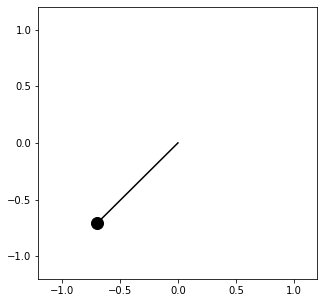

In [6]:
app = Application(dt=50)
furiko = Furiko()
app.add_figure('furiko', furiko.init_anim, furiko.update_anim)
app.mainloop()